# Analysis of genes/proteins identified as differentially expressed in patients with PASC

Data source for genes: https://github.com/RecoveryKG/Data_modeling/blob/main/Mann_Whiteney_U_test_longCovid_vs_normal.ipynb

In [17]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import kgfe

from kgfe import gene_names

## Load SPOKE

In [3]:
spoke_graph = kgfe.spoke_loader.load_spoke_igraph('../../graph_utils/spoke_2021.jsonl.gz', directed=True,
                                                    verbose=False)

In [4]:
gene_names.get_id('LILRA3')

11026

In [5]:
spoke_graph_ud = spoke_graph.copy()
spoke_graph_ud.to_undirected(combine_edges='first')
spoke_graph_ud.simplify(combine_edges='first')
spoke_graph_ud = kgfe.graph_info.largest_component(spoke_graph_ud)

In [6]:
genes_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Gene')

In [7]:
disease_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Disease')

In [8]:
disease_to_ids['DOID:9119']

'2166630'

## Lists of genes

In [9]:
diffexp_genes = """FIGF SOD2 F2R CA5A STK4 ADAMTS13 PRSS27 BOC HAO1
MMP10 IL8 LY75 NTF4 IRAK4 DAPP1 ANGPTL7 AGR2 CRH NPPC PLXDC1 BANK1 ERBB2IP SIRT5 CA14   
"""
diffexp_genes = diffexp_genes.split()

In [10]:
diffexp_genes_ncbi_ids = []
for g in diffexp_genes:
    try:
        diffexp_genes_ncbi_ids.append(gene_names.get_id(g))
    except:
        pass

In [11]:
genes_spoke_ids = [genes_to_ids[g] for g in diffexp_genes_ncbi_ids if g in genes_to_ids]

In [12]:
print('diffexp genes:', len(diffexp_genes_ncbi_ids), 'spoke-diffexp genes:', len(genes_spoke_ids))

diffexp genes: 21 spoke-diffexp genes: 21


## Calculate null model stats for Recover genes

In [14]:
genes_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud, list(set(genes_spoke_ids)))

In [15]:
genes_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud, 'Gene',\
                                                                 len(genes_spoke_ids),\
                                                                 use_degree_sampling=True,\
                                                                 input_id_set=genes_spoke_ids)

In [19]:
genes_null_results = pd.DataFrame(genes_null_results)


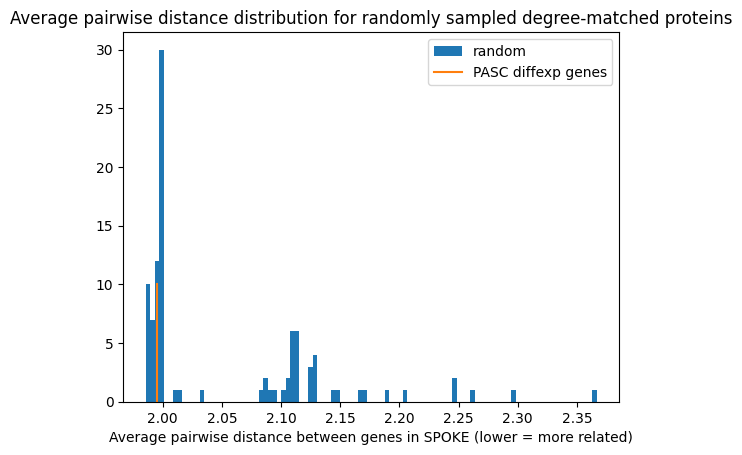

In [25]:
plt.hist(genes_null_results.average_pairwise_distance, bins=100, label='random')
plt.title('Average pairwise distance distribution for randomly sampled degree-matched proteins')
plt.plot([genes_stats['average_pairwise_distance'], genes_stats['average_pairwise_distance']],
         [0, 10], label='PASC diffexp genes')
plt.xlabel('Average pairwise distance between genes in SPOKE (lower = more related)')
plt.legend()

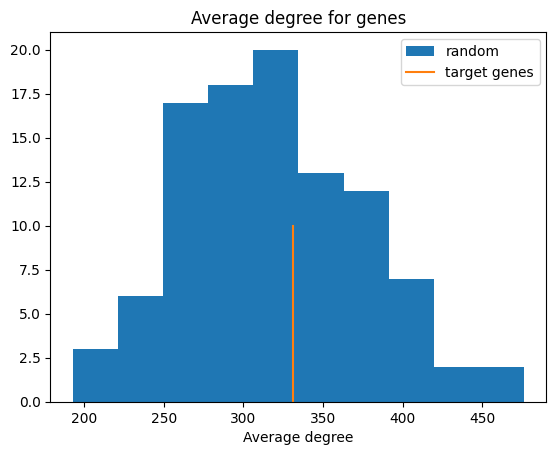

In [24]:
plt.hist(genes_null_results.degree_mean, bins=10, label='random')
plt.title('Average degree for genes')
plt.plot([genes_stats['degree_mean'], genes_stats['degree_mean']],
         [0, 10], label='target genes')
plt.xlabel('Average degree')
plt.legend()

## Steiner trees for PASC genes

In [27]:
import ipycytoscape

In [28]:
# TODO: display the node category somewhere, and display the edge categories
graph_style = [{'selector': 'node[feature_name]',
                             'style': {
                                  'font-family': 'helvetica',
                                  'font-size': '20px',
                                 'text-valign': 'top',
                                 'label': 'data(feature_name)',
                        }},
                        {'selector': 'node[category="Protein"]',
                         'style': {
                             'background-color': 'blue',
                         }},
                        {'selector': 'node[in_query=1]',
                         'style': {
                             'border-width': '5px',
                             'border-color': 'red',
                         }},
                        {'selector': 'edge[type]',
                         'style': {
                             'label': 'data(type)',
                         }},
                        {"selector": "edge.directed",
                         "style": {
                            "curve-style": "bezier",
                            "target-arrow-shape": "triangle",
                    }},

                    ]

In [26]:
st, subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                            genes_spoke_ids,
                                                            method='takahashi')

In [31]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…